In [1]:
import numpy as np
import os
import sys
import astropy as ast
from astropy.io import ascii
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import scipy as sp
from astropy.timeseries import LombScargle
from astropy import units as u
import gc
from view_and_clean import get_telescope, find_header_line, modified_zscore, df_extract, individual_plotter, grid_plotter, offset_corrector, offset_corrector_window
from metrics import mean_med_flux, fit_plotter_flux, curve_fitter_flux,\
    largest_amplitude, offset_warning, chi, percentile_amplitude, plot_percentile_amplitude, \
        compute_lomb_scargle, plot_periodogram, plot_phase_fold, amplitude_per_period, amplitude_per_period_plot, sed_plotter

In [2]:
df_lmc = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/final_lmc_ysgcands.csv', comment='#') # , sep="\\s+"
df_smc = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/final_smc_ysgcands.csv', comment='#') # , sep="\\s+"
coords = pd.read_csv('merged_smc_lmc_coords.csv', comment='#', sep="\\s+", names=['RA', 'DEC'])
plt.rcParams['font.family'] = 'serif'

In [3]:
def info(index, g=True, change_period=None):
        # plots
        # individual_plotter(index, seeoutliers=True)
        df, telescopes = offset_corrector(index, g=g)
        lombs = compute_lomb_scargle(index, df=df, telescopes=telescopes, g=g, auto=False, samples_per_peak=10)
        if change_period is None:
                best_period = lombs['best_period']
        else:
                best_period = change_period
        plot_periodogram(index, lombs['frequency'], lombs['power'], lombs['best_frequency'], lombs['false_alarm_level'], lombs['peaks'], lombs['observation_period'], show_best=True)
        plot_phase_fold(index, best_period, phase_bins=2)
        sed_plotter(index)
        # computations
        overall_mean, means, overall_median, medians, overall_mags_mean, overall_mags_median, mags_means, mags_medians = mean_med_flux(index, df=df, telescopes=telescopes)
        chi_squared_95, chi2_threshold_95, dof_95, chi_flag_95 = chi(index, df=df, telescopes=telescopes, g=g, confidence=0.95)
        chi_squared_997, chi2_threshold_997, dof_997, chi_flag_997 = chi(index, df=df, telescopes=telescopes, g=g, confidence=0.997)
        chi_squared_68, chi2_threshold_68, dof_68, chi_flag_68 = chi(index, df=df, telescopes=telescopes, g=g, confidence=0.68)
        # offset_flag = offset_warning(index)
        lombs = compute_lomb_scargle(index, df=df, telescopes=telescopes, g=g, auto=False, median=False, subtract_median=False, samples_per_peak=10, report=False)
        alarm_level_flag = lombs['alarm_level_flag']
        print(lombs['peaks'])
        amplitude_5, lower_percentile_5, upper_percentile_5, mag_amplitude_5 = percentile_amplitude(index, df=df, telescopes=telescopes, g=g, tails=5)
        amplitude_1, lower_percentile_1, upper_percentile_1, mag_amplitude_1 = percentile_amplitude(index, df=df, telescopes=telescopes, g=g, tails=1)
        largest_amp = largest_amplitude(index, df=df, telescopes=telescopes, g=g)
        result = amplitude_per_period(index, best_period, df=df, telescopes=telescopes, g=g, report=False)
        # std_amp = result['std_amplitude']
        

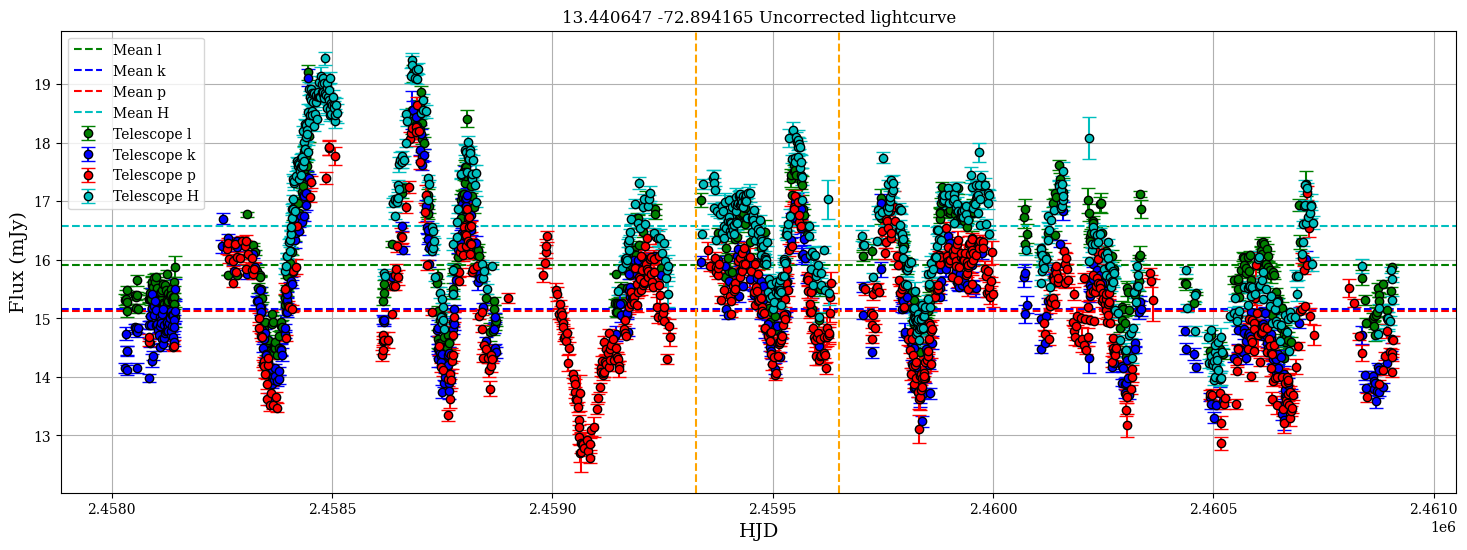

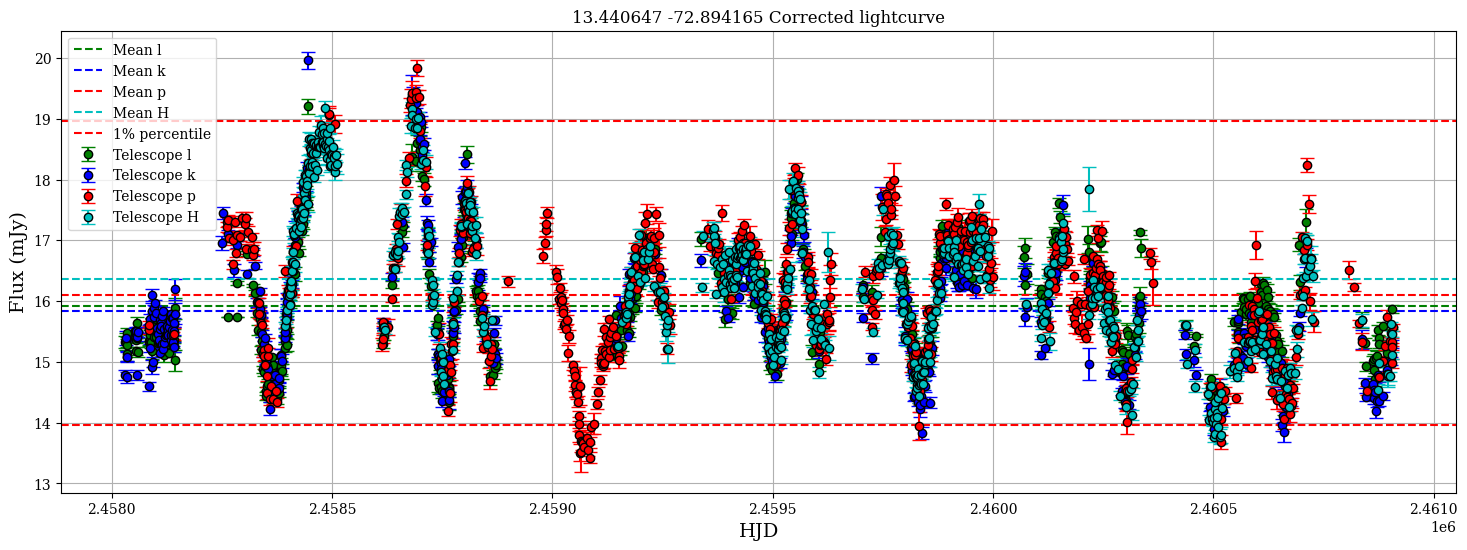

Best frequency: 0.001290 1/day, Best period: 775.36 days, Max power: 0.124, False alarm probability: 1.187e-58
False alarm level for 1.0%: 1.295e-02
Grid sampled at 19658 points


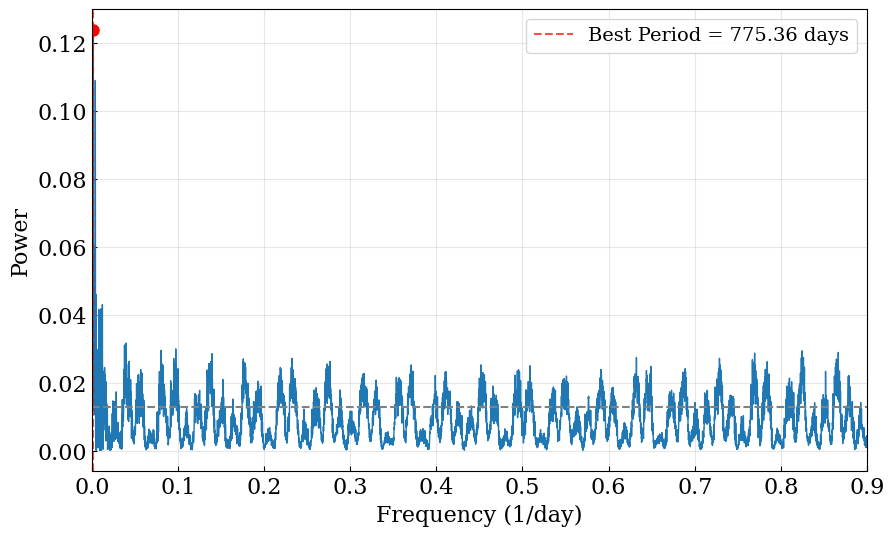

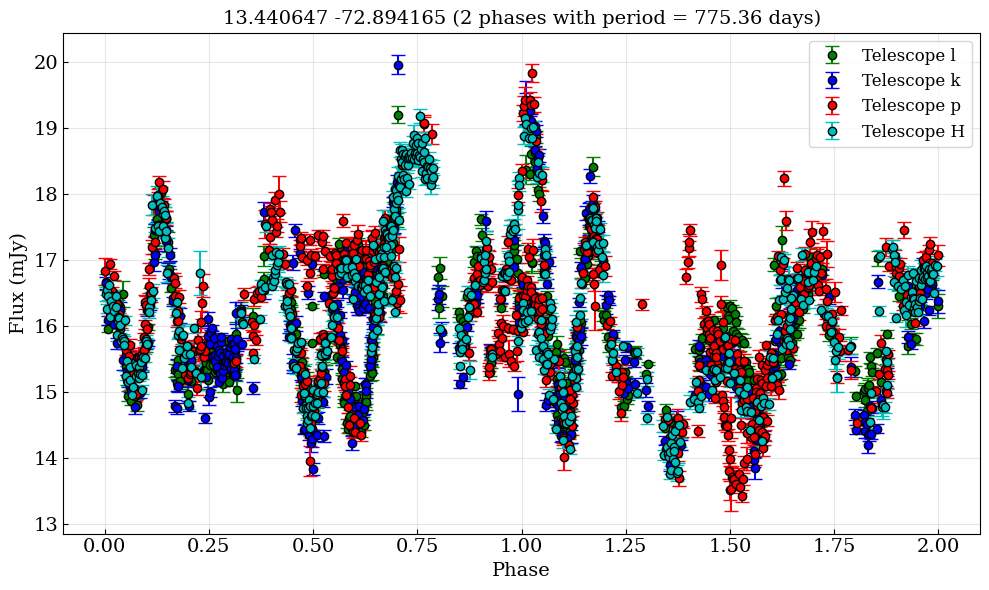

Average scatter (amplitude) per 10 point phase bin: 1.288 mJy


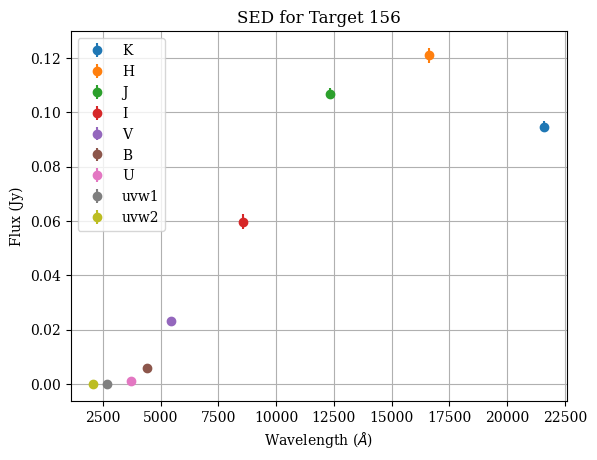

[7.86470924e-04 1.28971940e-03 2.15896677e-03 2.66221525e-03
 3.43996290e-03 3.94321137e-03 4.58370943e-03 5.08695791e-03
 5.63595625e-03 6.18495459e-03 7.51170057e-03 7.96919919e-03
 8.79269670e-03 9.57044435e-03 1.03481920e-02 1.08514405e-02
 1.13546889e-02 1.21324366e-02 1.29559341e-02 1.34591826e-02
 1.42369302e-02 1.46944288e-02 1.52434272e-02 1.61584244e-02
 1.70276718e-02 1.78969191e-02 2.44391494e-02 2.62691438e-02
 2.67723923e-02 2.75958898e-02 2.82363879e-02 3.52818665e-02
 3.61968638e-02 3.73863602e-02 3.78438588e-02 3.83013574e-02
 3.90333552e-02 3.97653530e-02 4.04973508e-02 4.09548494e-02
 4.14580979e-02 4.23273452e-02 4.31965926e-02 4.36998411e-02
 4.42945893e-02 4.49350873e-02 4.56670851e-02 5.10198189e-02
 5.18433164e-02 5.23008150e-02 5.28955632e-02 5.33530619e-02
 5.41765594e-02 5.46340580e-02 5.53660558e-02 5.59150541e-02
 5.66470519e-02 5.71960502e-02 5.79280480e-02 5.84312965e-02
 5.89345450e-02 5.97580425e-02 6.02155411e-02 7.76004885e-02
 7.83782361e-02 7.888148

In [4]:
info(156) # 16, 25, 30

# Based on mean mag — amplitude diagram (topcat picking):

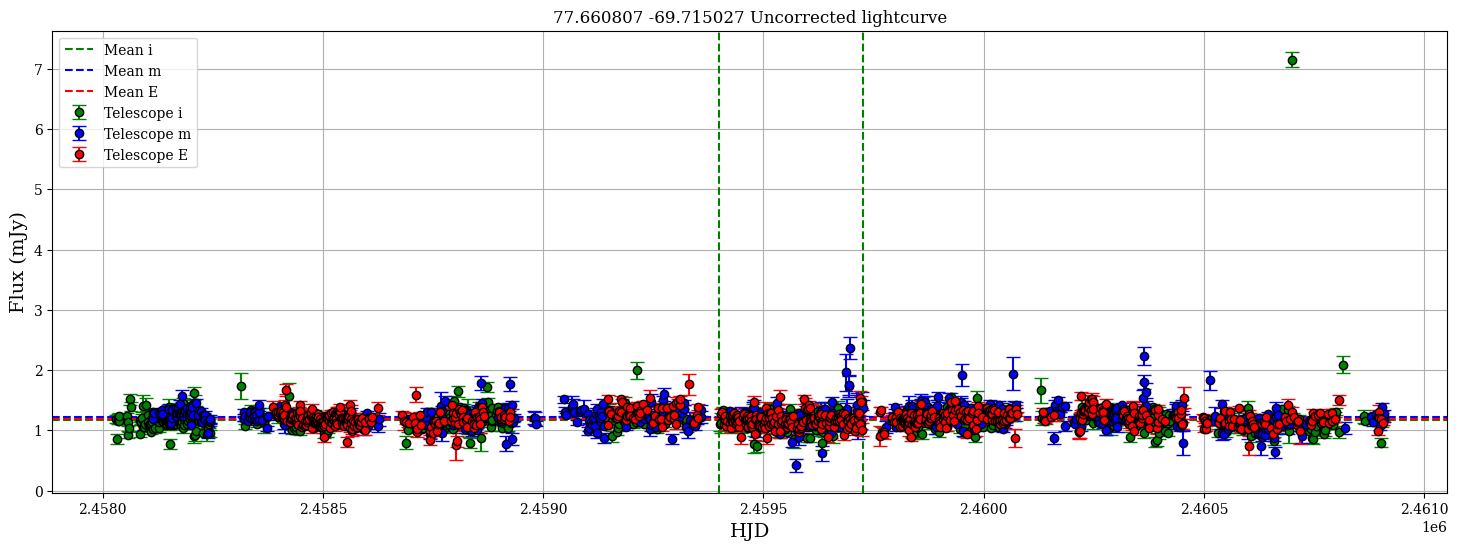

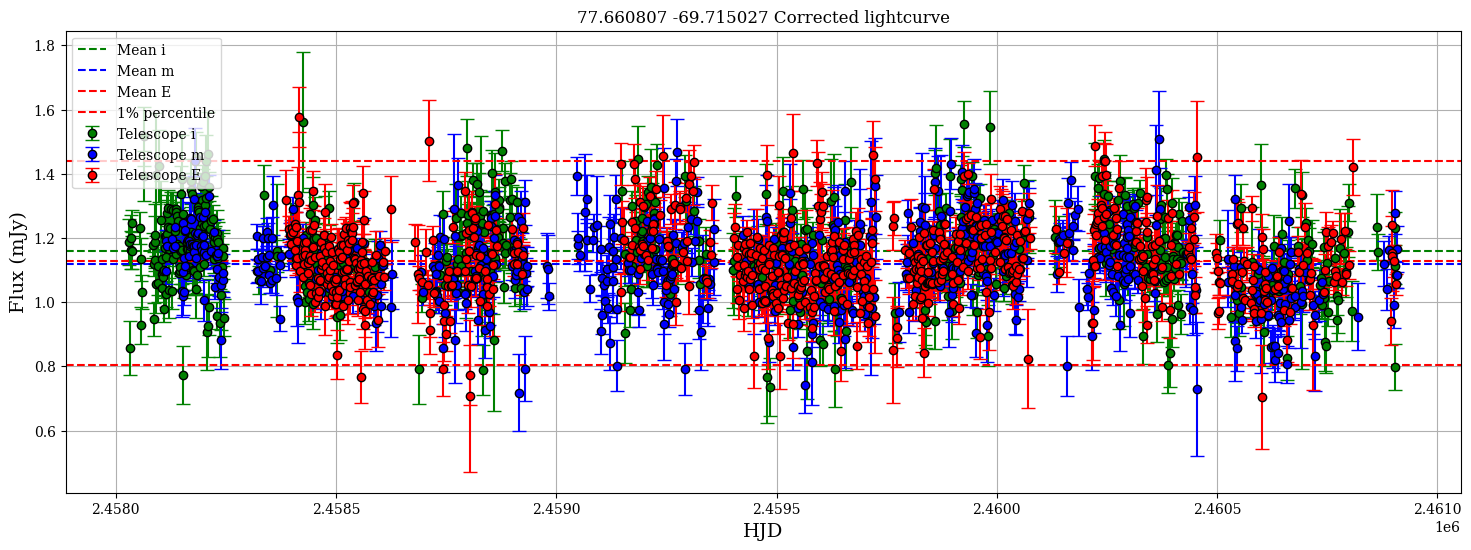

Best frequency: 0.001000 1/day, Best period: 1000.22 days, Max power: 0.157, False alarm probability: 1.263e-68
False alarm level for 1.0%: 1.459e-02
Grid sampled at 17689 points


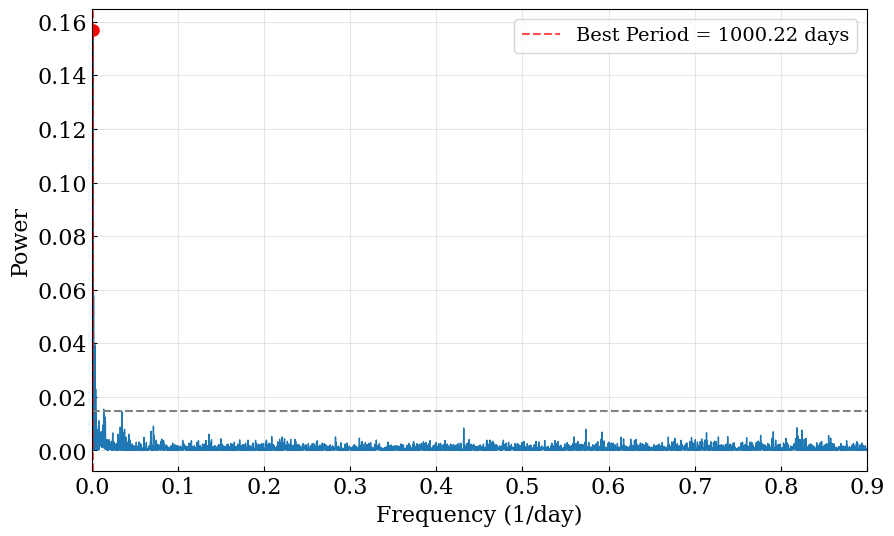

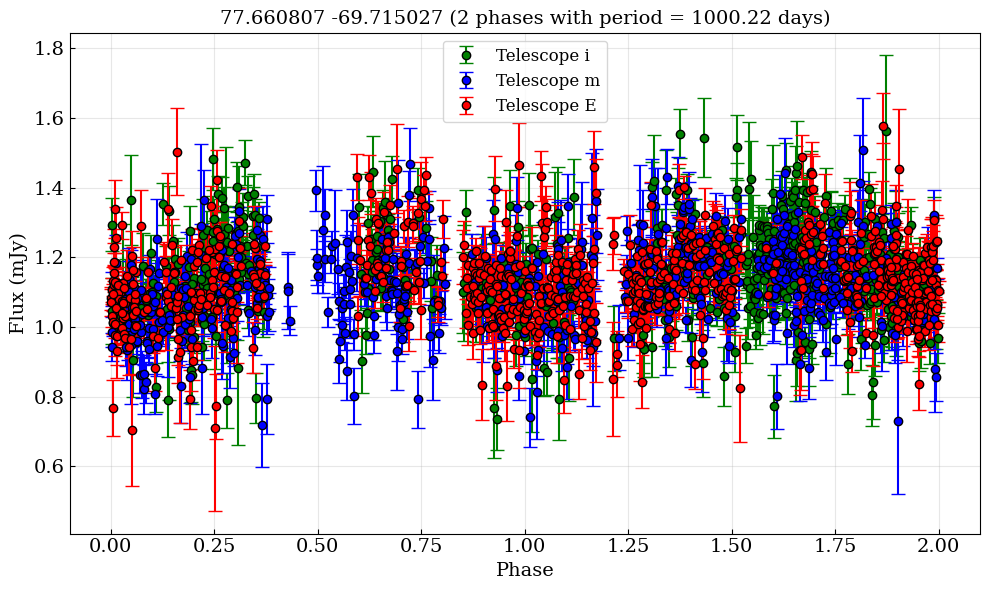

Average scatter (amplitude) per 10 point phase bin: 0.343 mJy


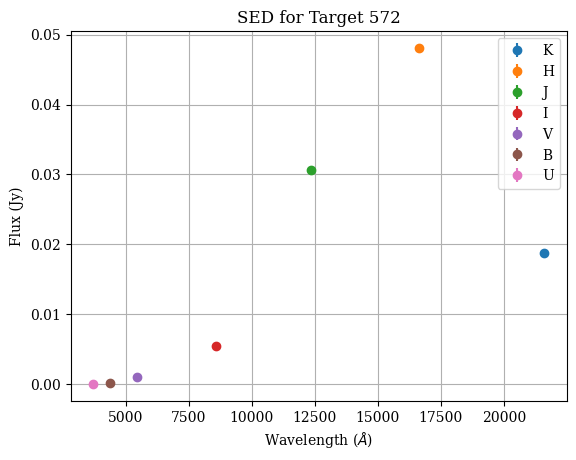

[0.00099978 0.0018641  0.00384697 0.00435539 0.01371045]
Amplitude metrics:
	Lower 5% percentile: -0.19 mJy, 16.08 mags
	Upper 5% percentile: 0.21 mJy, 16.47 mags
	Percentile amplitude of variability (excluding the brightest and dimmest 5% of data) (g-band: True): 0.40 mJy, 0.38 mags
Amplitude metrics:
	Lower 1% percentile: -0.33 mJy, 16.00 mags
	Upper 1% percentile: 0.31 mJy, 16.64 mags
	Percentile amplitude of variability (excluding the brightest and dimmest 1% of data) (g-band: True): 0.64 mJy, 0.63 mags
	Largest amplitude of variability (g-band: True): 0.87 mJy, 0.88 mags
	Average amplitude across all periods: 0.809 mJy
	Standard deviation of amplitudes: 0.013 mJy
	Average amplitude (0.809 mJy) is greater than 5 sigma (0.013 mJy). This indicates consistent variability across periods.


In [5]:
info(572) # purple dot on the dim (far right side)

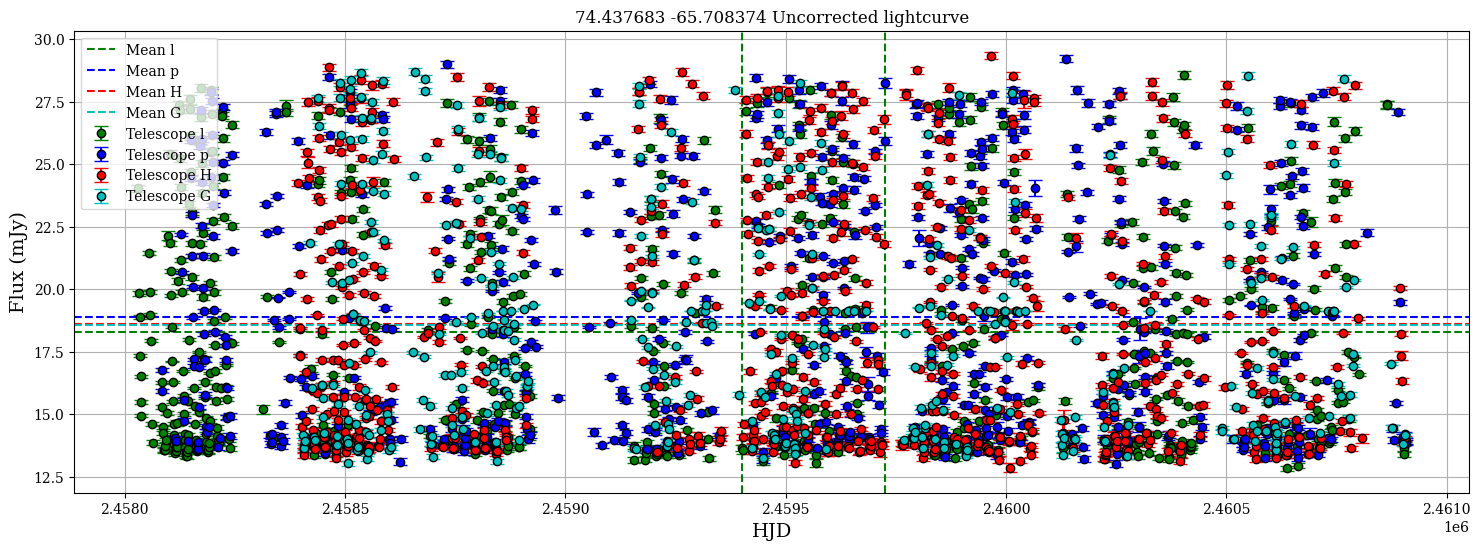

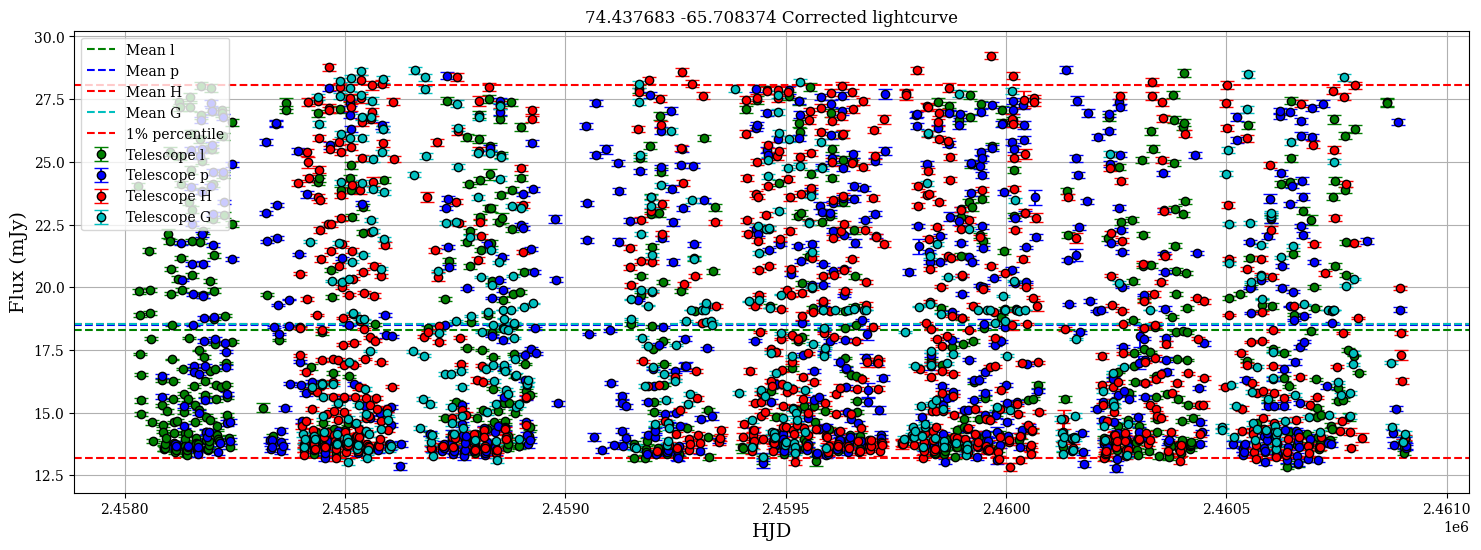

Best frequency: 0.002820 1/day, Best period: 354.60 days, Max power: 0.028, False alarm probability: 3.714e-11
False alarm level for 1.0%: 1.189e-02
Grid sampled at 21160 points


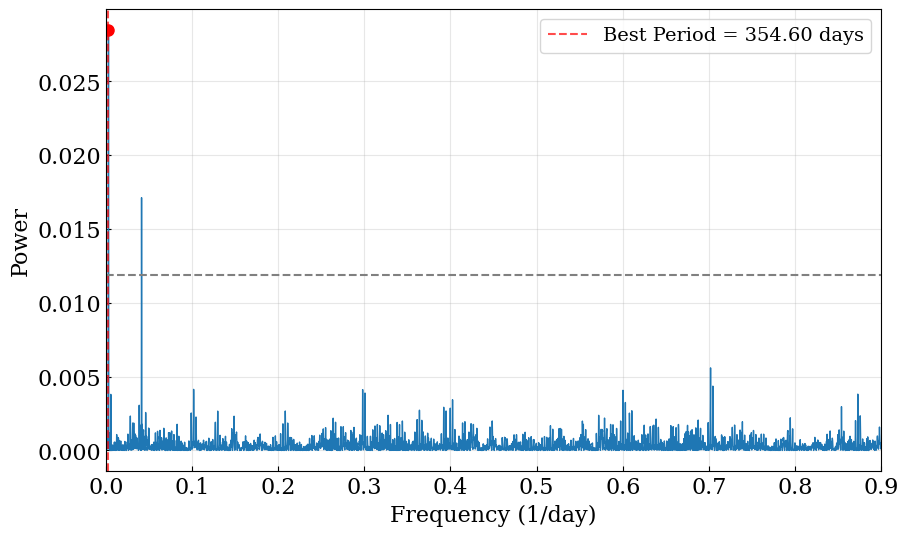

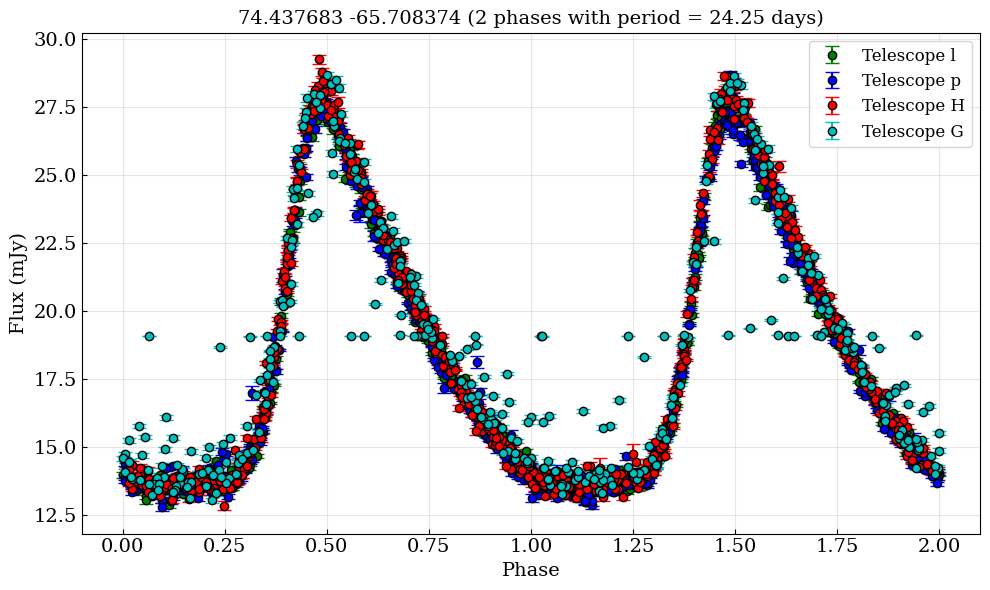

Average scatter (amplitude) per 10 point phase bin: 1.821 mJy


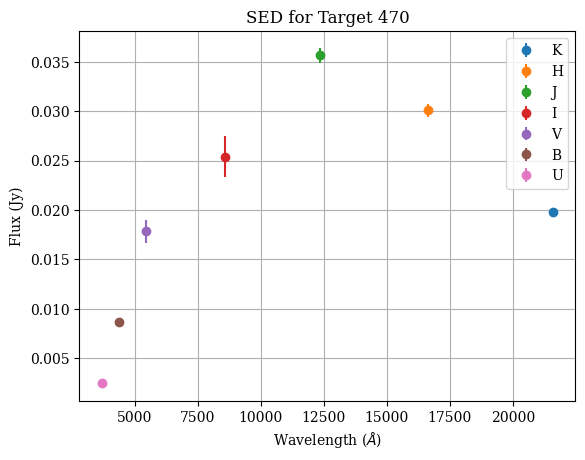

[0.00282007 0.0412421 ]
Amplitude metrics:
	Lower 5% percentile: -3.56 mJy, 12.81 mags
	Upper 5% percentile: 10.19 mJy, 13.58 mags
	Percentile amplitude of variability (excluding the brightest and dimmest 5% of data) (g-band: True): 13.75 mJy, 0.76 mags
Amplitude metrics:
	Lower 1% percentile: -3.84 mJy, 12.78 mags
	Upper 1% percentile: 11.06 mJy, 13.60 mags
	Percentile amplitude of variability (excluding the brightest and dimmest 1% of data) (g-band: True): 14.91 mJy, 0.82 mags
	Largest amplitude of variability (g-band: True): 16.45 mJy, 0.90 mags
	Average amplitude across all periods: 14.155 mJy
	Standard deviation of amplitudes: 1.182 mJy
	Average amplitude (14.155 mJy) is greater than 5 sigma (1.182 mJy). This indicates consistent variability across periods.


In [6]:
info(470, change_period = 24.247) # second peak is at frequency of 0.0412421, period of 24.247 days

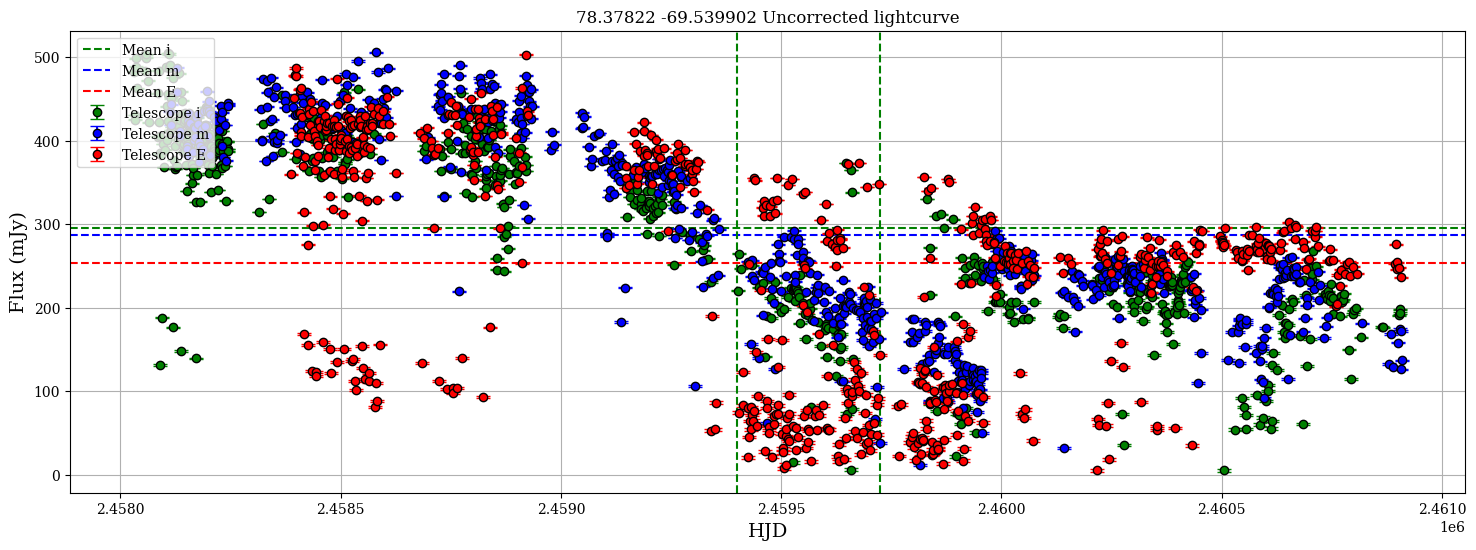

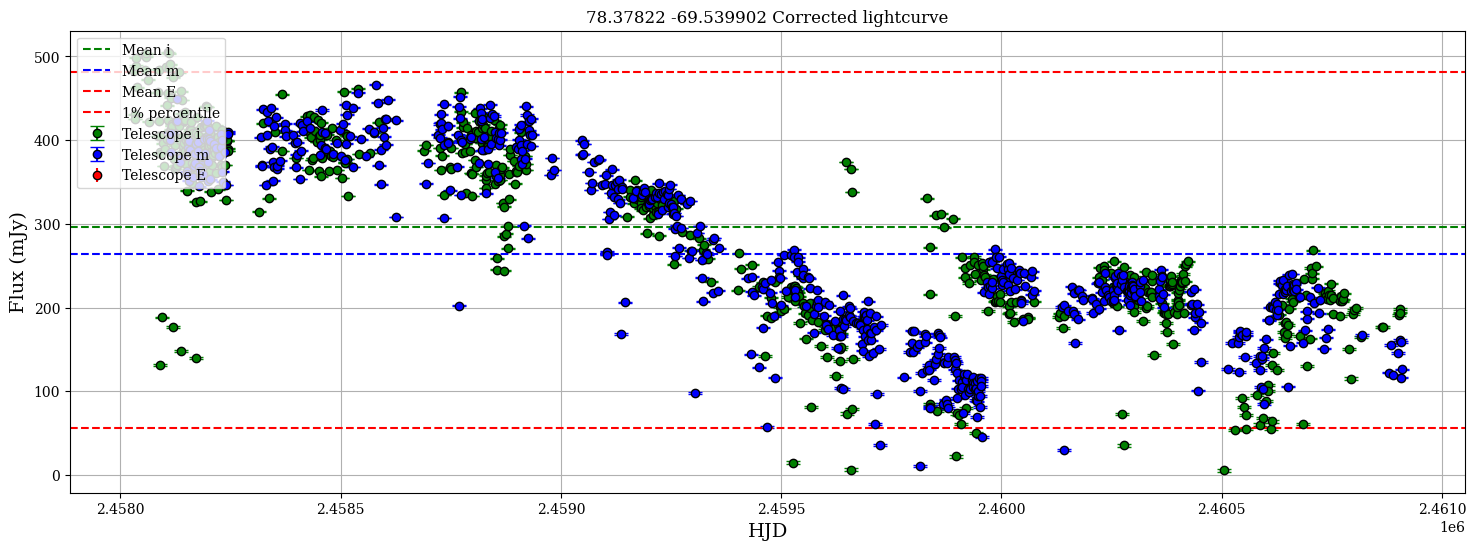

Best frequency: 0.003032 1/day, Best period: 329.83 days, Max power: 0.155, False alarm probability: 9.957e-42
False alarm level for 1.0%: 2.183e-02
Grid sampled at 11160 points


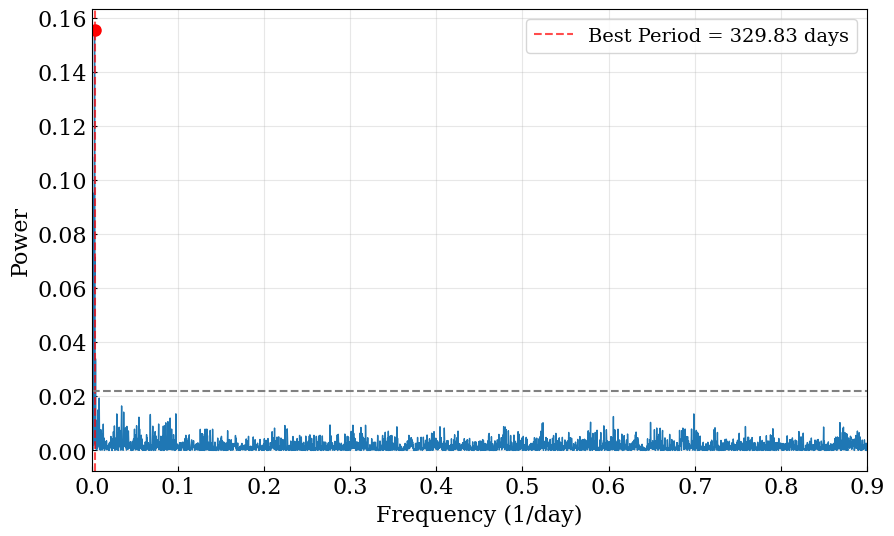

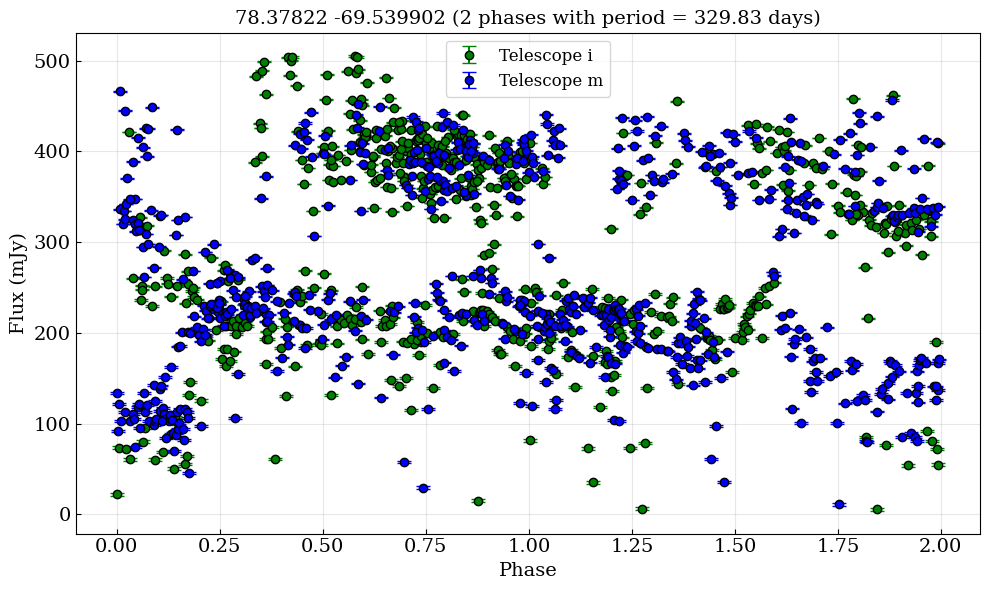

Average scatter (amplitude) per 10 point phase bin: 243.720 mJy


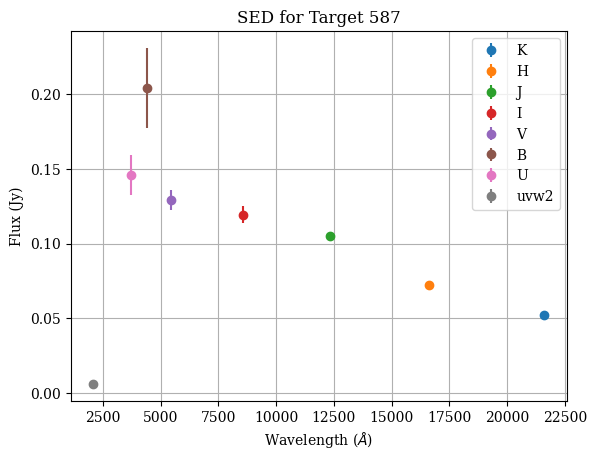

[0.00142003 0.00303183 0.0041601 ]
Amplitude metrics:
	Lower 5% percentile: -148.39 mJy, 9.82 mags
	Upper 5% percentile: 176.05 mJy, 11.37 mags
	Percentile amplitude of variability (excluding the brightest and dimmest 5% of data) (g-band: True): 324.44 mJy, 1.54 mags
Amplitude metrics:
	Lower 1% percentile: -195.35 mJy, 9.69 mags
	Upper 1% percentile: 230.46 mJy, 12.03 mags
	Percentile amplitude of variability (excluding the brightest and dimmest 1% of data) (g-band: True): 425.82 mJy, 2.33 mags
	Largest amplitude of variability (g-band: True): 499.46 mJy, 4.90 mags
	Average amplitude across all periods: 273.973 mJy
	Standard deviation of amplitudes: 69.327 mJy


In [7]:
info(587)

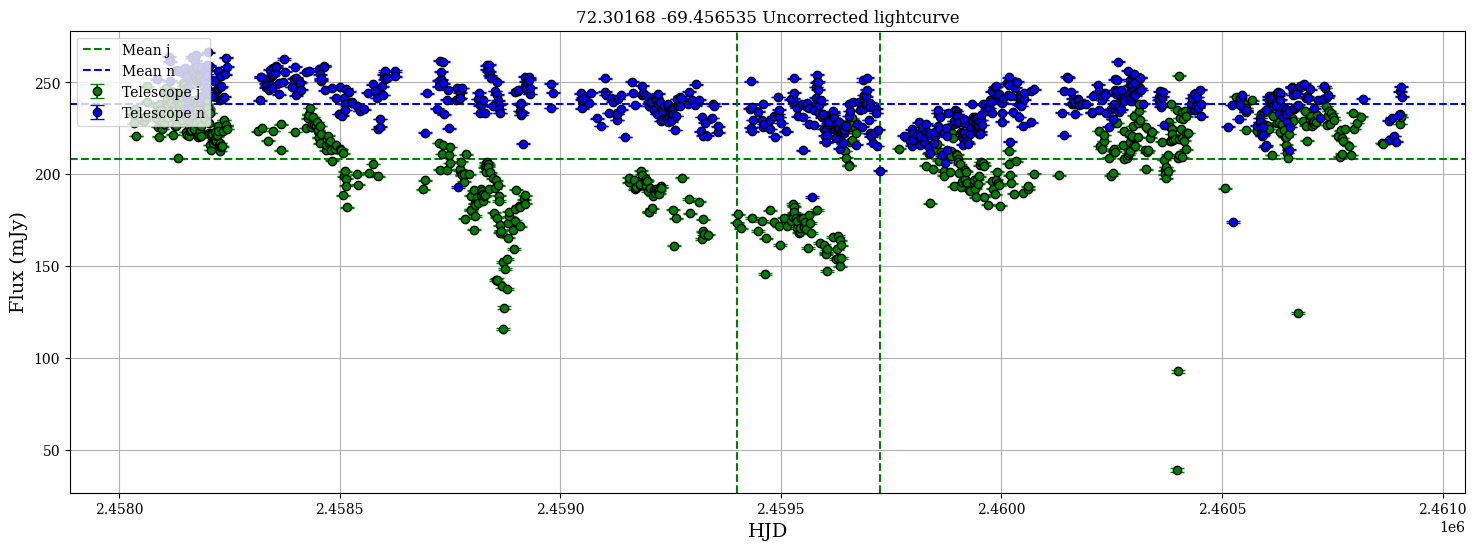

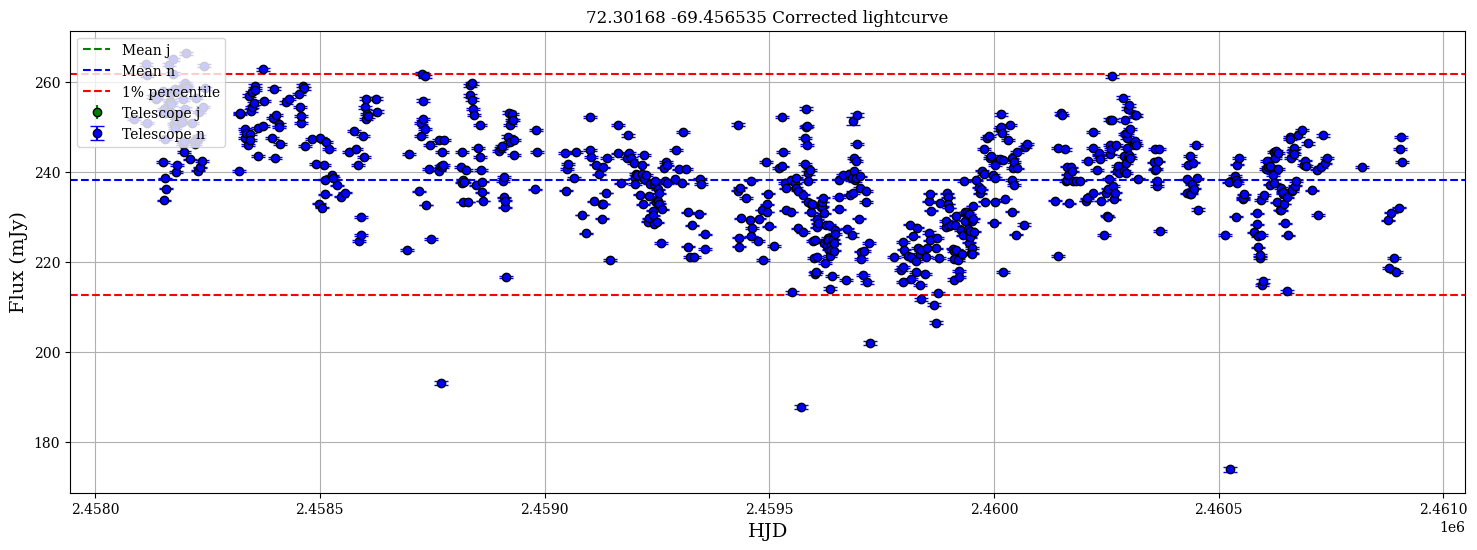

Best frequency: 0.001008 1/day, Best period: 991.92 days, Max power: 0.066, False alarm probability: 8.581e-07
False alarm level for 1.0%: 3.876e-02
Grid sampled at 6007 points


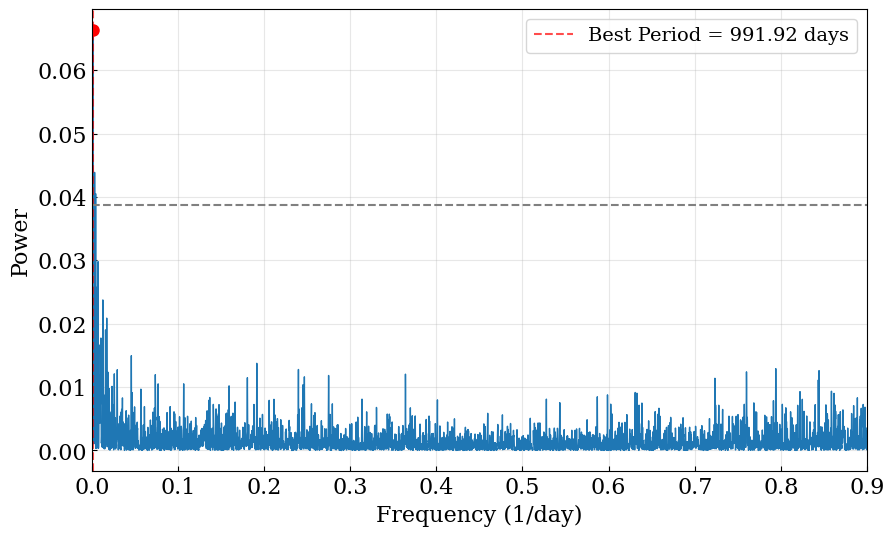

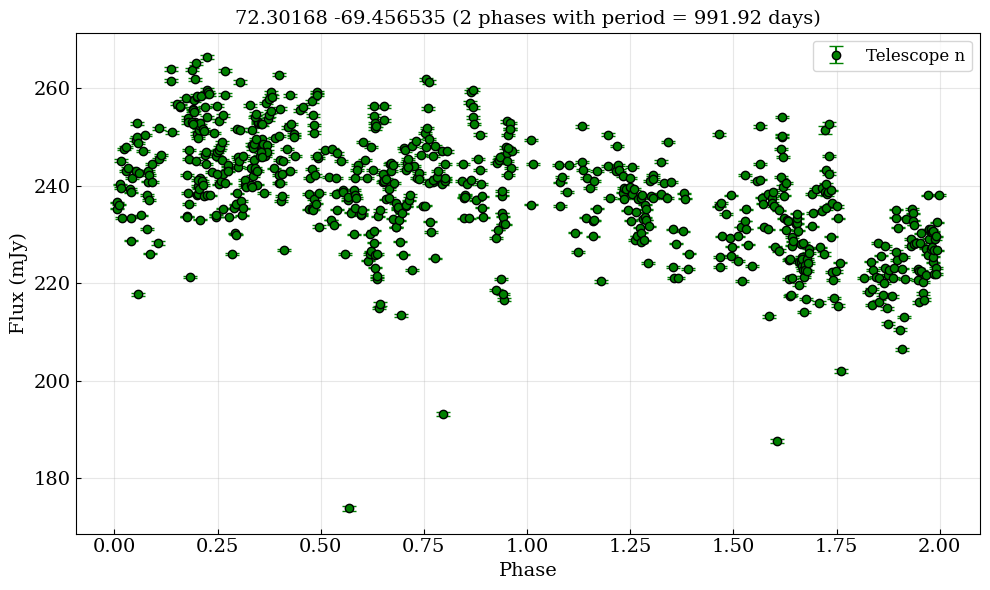

Average scatter (amplitude) per 10 point phase bin: 24.781 mJy


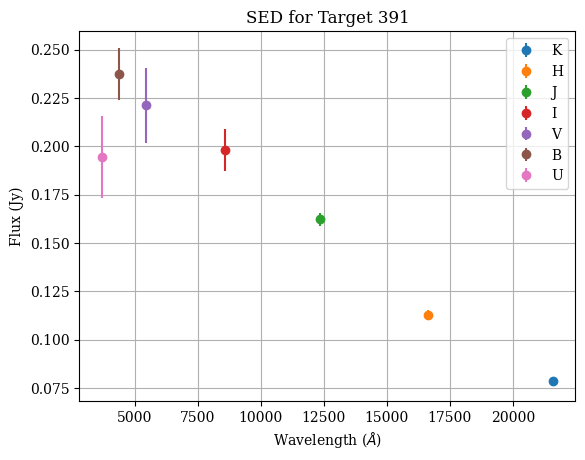

[0.00100815 0.0031044 ]
Amplitude metrics:
	Lower 5% percentile: -18.67 mJy, 10.38 mags
	Upper 5% percentile: 17.88 mJy, 10.54 mags
	Percentile amplitude of variability (excluding the brightest and dimmest 5% of data) (g-band: True): 36.55 mJy, 0.17 mags
Amplitude metrics:
	Lower 1% percentile: -25.90 mJy, 10.36 mags
	Upper 1% percentile: 23.29 mJy, 10.58 mags
	Percentile amplitude of variability (excluding the brightest and dimmest 1% of data) (g-band: True): 49.19 mJy, 0.23 mags
	Largest amplitude of variability (g-band: True): 92.51 mJy, 0.46 mags
	Average amplitude across all periods: 75.661 mJy
	Standard deviation of amplitudes: 8.754 mJy
	Average amplitude (75.661 mJy) is greater than 5 sigma (8.754 mJy). This indicates consistent variability across periods.


In [8]:
info(391)

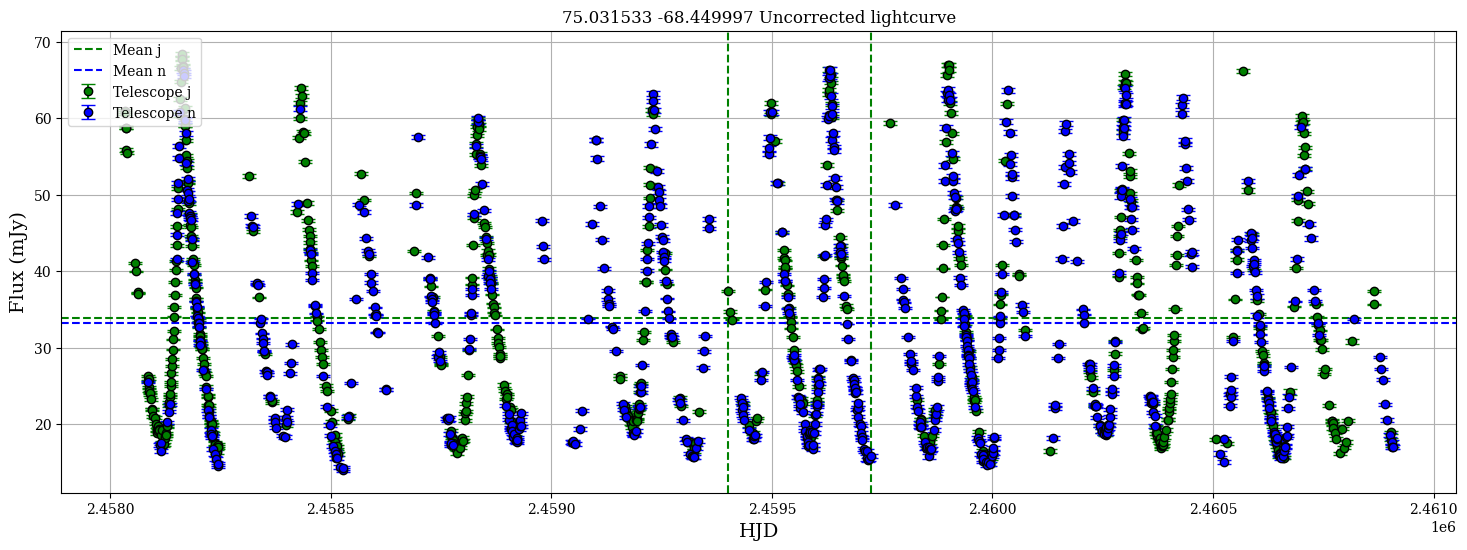

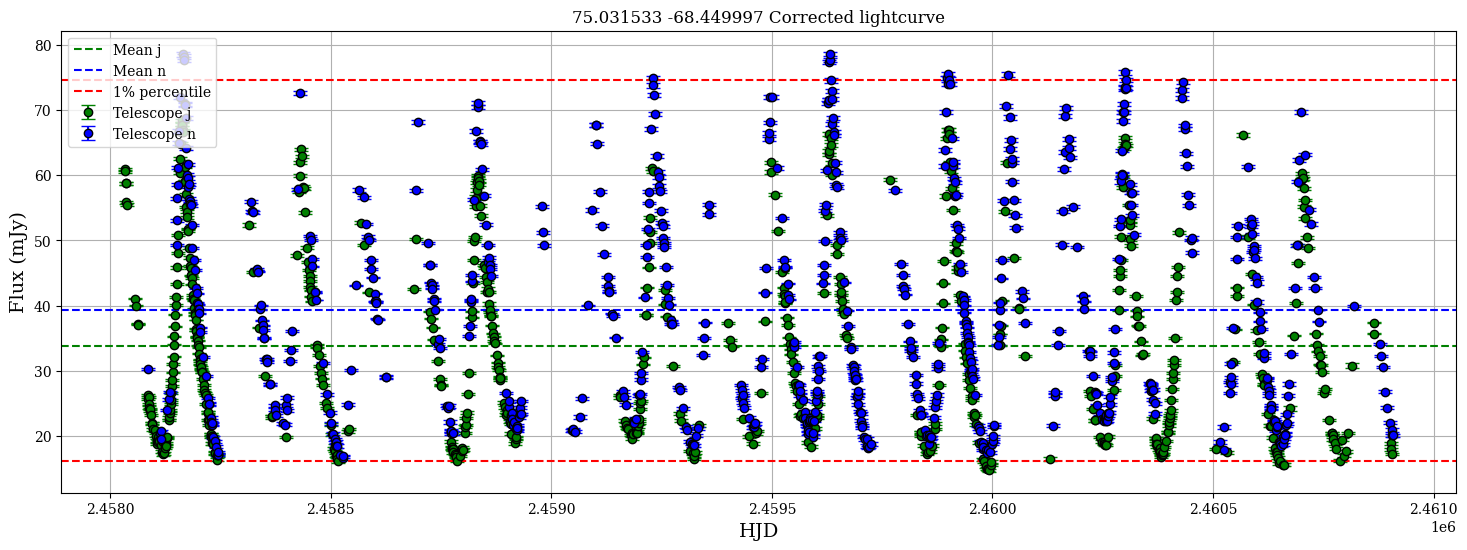

Best frequency: 0.007502 1/day, Best period: 133.30 days, Max power: 0.737, False alarm probability: 0.000e+00
False alarm level for 1.0%: 2.229e-02
Grid sampled at 11232 points


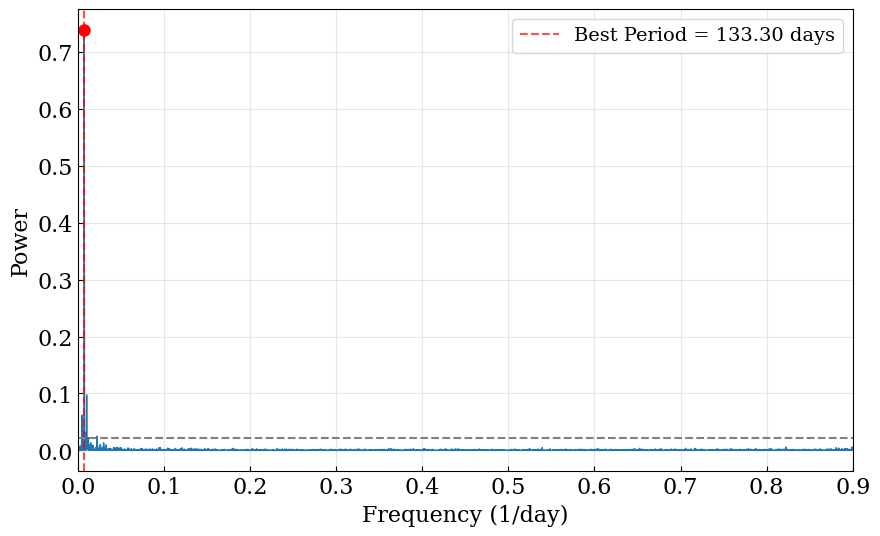

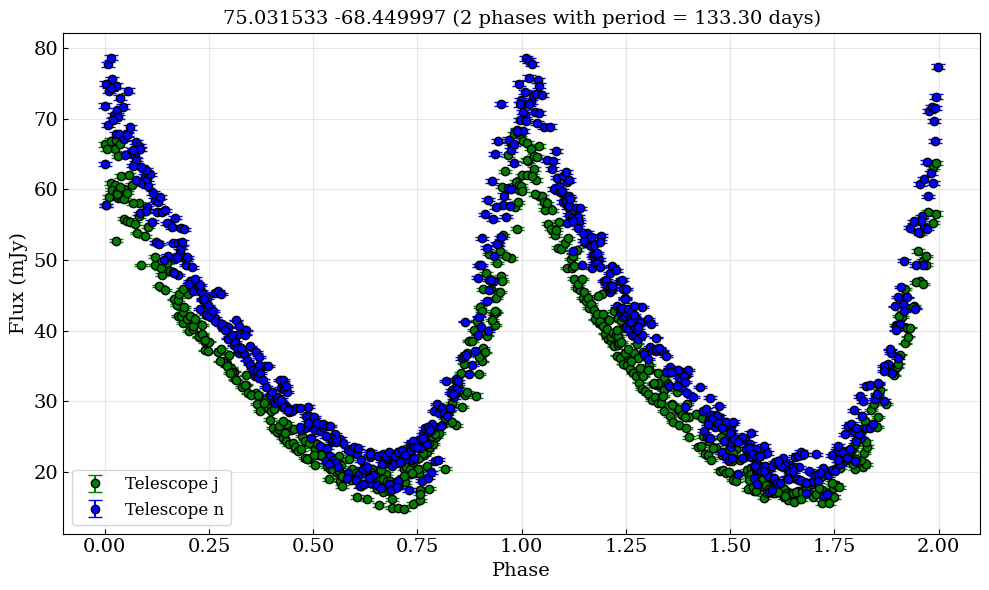

Average scatter (amplitude) per 10 point phase bin: 10.018 mJy


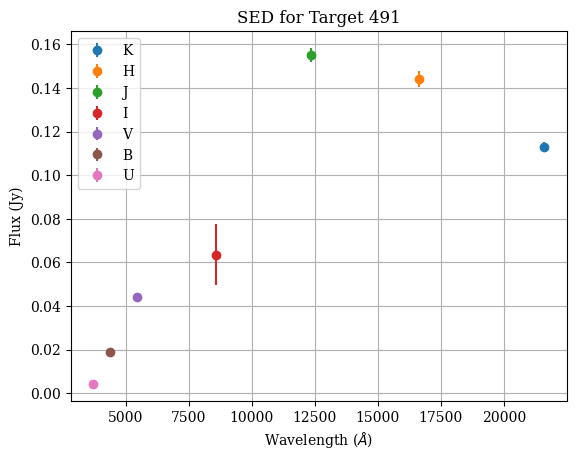

[0.00469937 0.00750194 0.01030451 0.01230634 0.02247567]
Amplitude metrics:
	Lower 5% percentile: -15.44 mJy, 11.84 mags
	Upper 5% percentile: 33.75 mJy, 13.28 mags
	Percentile amplitude of variability (excluding the brightest and dimmest 5% of data) (g-band: True): 49.19 mJy, 1.44 mags
Amplitude metrics:
	Lower 1% percentile: -16.93 mJy, 11.72 mags
	Upper 1% percentile: 41.46 mJy, 13.38 mags
	Percentile amplitude of variability (excluding the brightest and dimmest 1% of data) (g-band: True): 58.39 mJy, 1.66 mags
	Largest amplitude of variability (g-band: True): 63.83 mJy, 1.82 mags
	Average amplitude across all periods: 55.106 mJy
	Standard deviation of amplitudes: 4.050 mJy
	Average amplitude (55.106 mJy) is greater than 5 sigma (4.050 mJy). This indicates consistent variability across periods.


In [9]:
info(491)

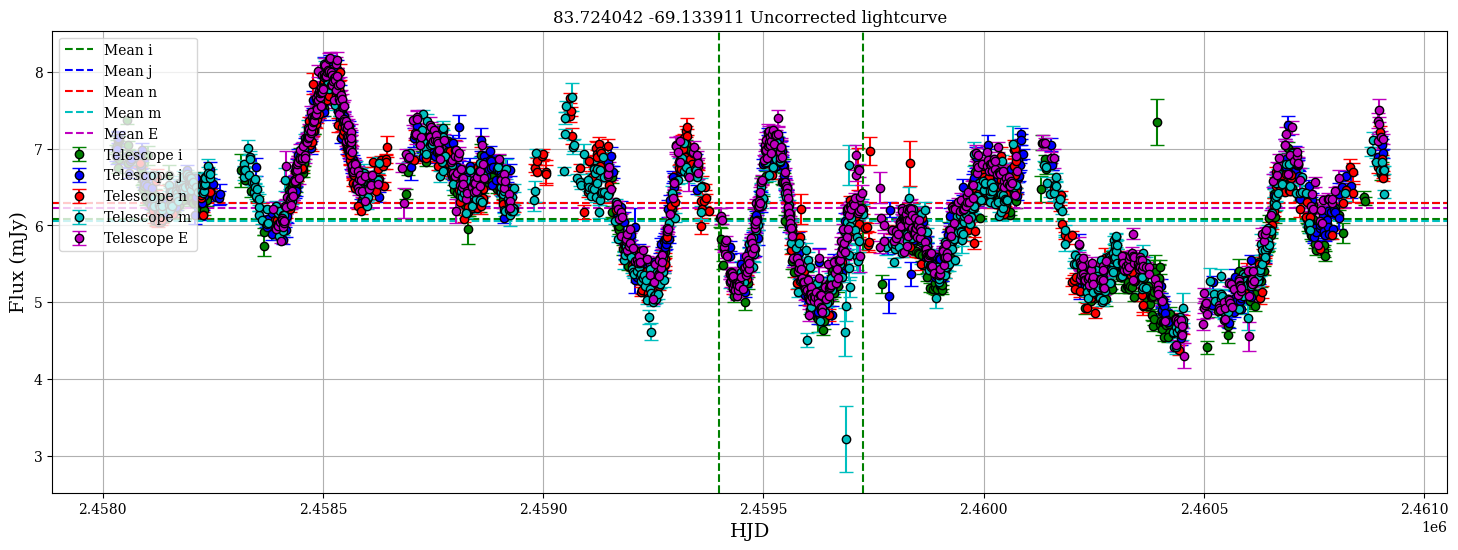

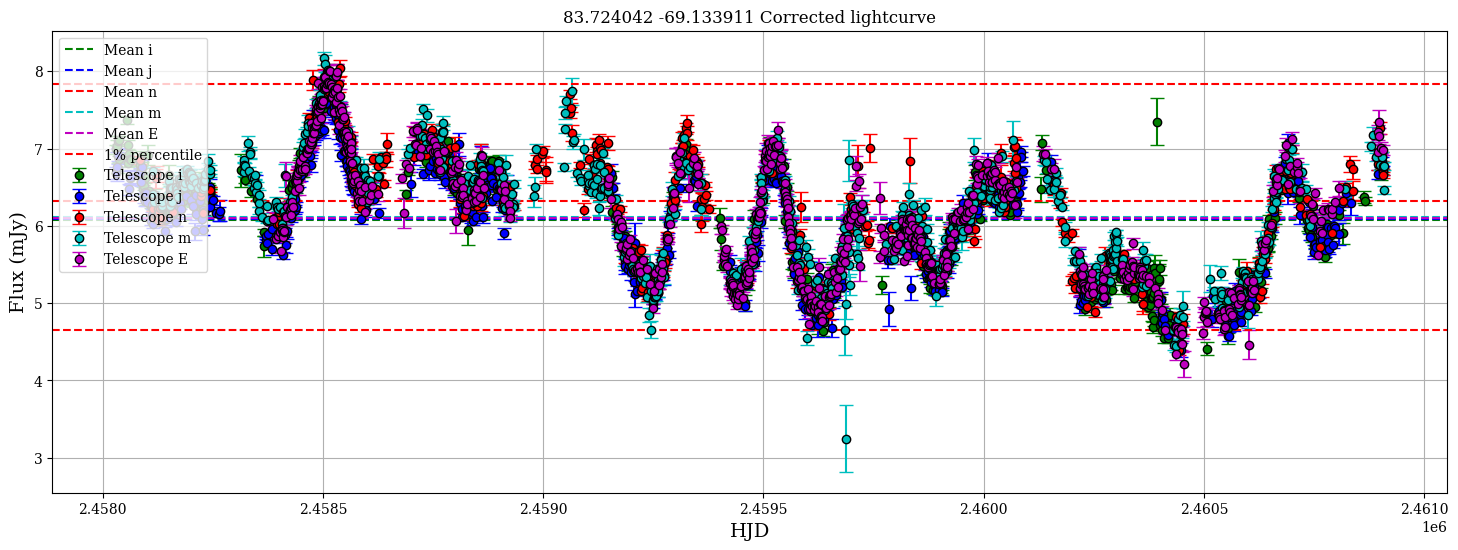

Best frequency: 0.003154 1/day, Best period: 317.05 days, Max power: 0.150, False alarm probability: 2.373e-101
False alarm level for 1.0%: 9.860e-03
Grid sampled at 27060 points


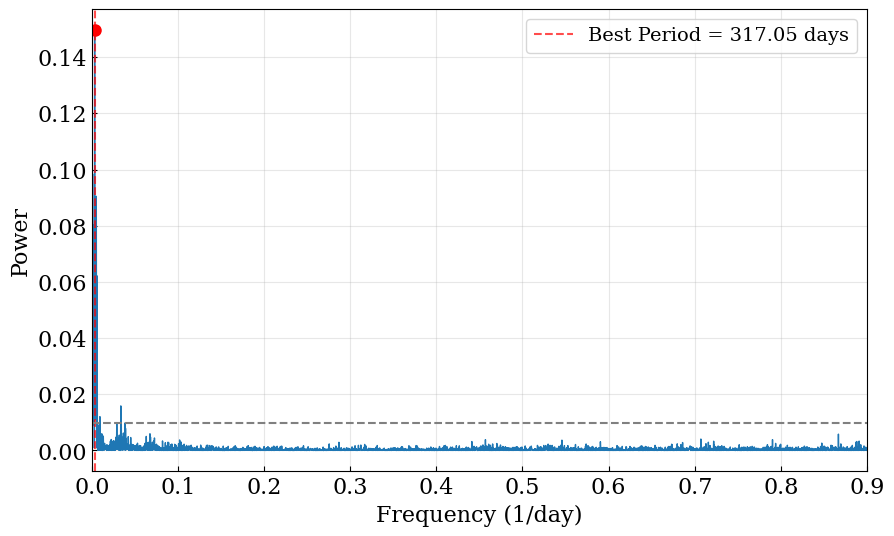

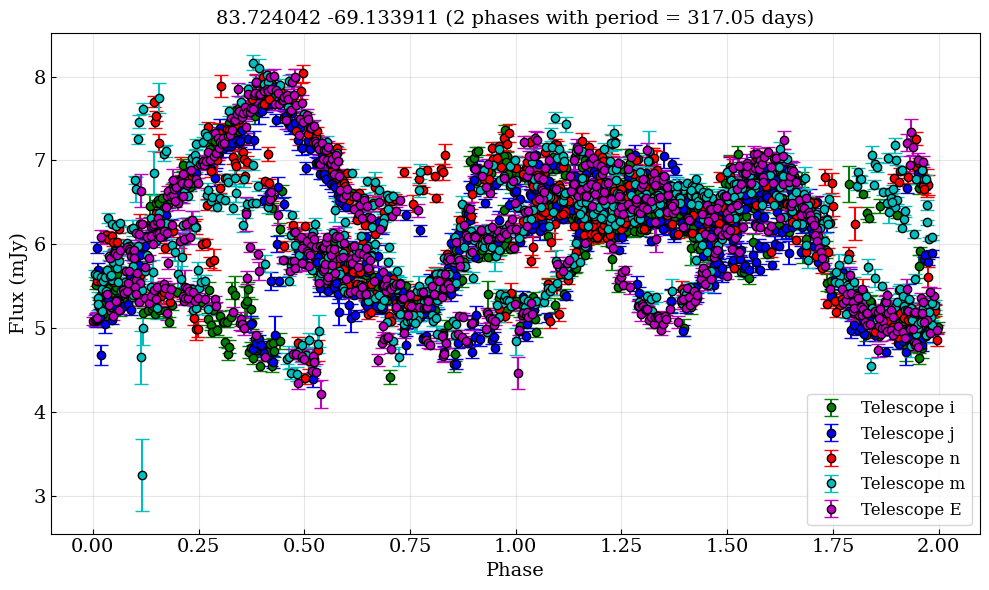

Average scatter (amplitude) per 10 point phase bin: 1.574 mJy


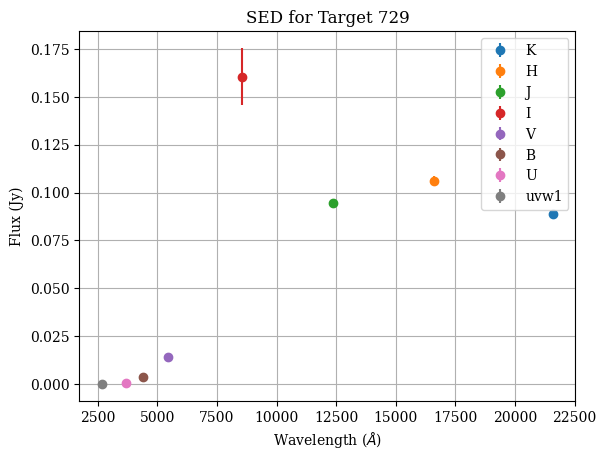

[0.00076119 0.00142589 0.00202412 0.00258911 0.00315411 0.00368587
 0.00415116 0.00458321 0.0050485  0.00601232 0.00926934 0.02884475
 0.03356411]
Amplitude metrics:
	Lower 5% percentile: -1.26 mJy, 14.25 mags
	Upper 5% percentile: 1.03 mJy, 14.66 mags
	Percentile amplitude of variability (excluding the brightest and dimmest 5% of data) (g-band: True): 2.29 mJy, 0.41 mags
Amplitude metrics:
	Lower 1% percentile: -1.57 mJy, 14.17 mags
	Upper 1% percentile: 1.60 mJy, 14.73 mags
	Percentile amplitude of variability (excluding the brightest and dimmest 1% of data) (g-band: True): 3.18 mJy, 0.56 mags
	Largest amplitude of variability (g-band: True): 4.92 mJy, 1.00 mags
	Average amplitude across all periods: 2.585 mJy
	Standard deviation of amplitudes: 0.721 mJy


In [10]:
info(729)